<a href="https://colab.research.google.com/github/hirokame/BPBG/blob/main/BackProp_withBG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import cupy as cp
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

# download MNIST dataset
train_data = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('../data', train=False, transform=transform)

# set DataLoader
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [37]:
# Set the layer number and size
input_size = 784
hidden_size = [100,50]
output_size = 10


# Set the device
cuda0 = torch.device('cuda:0')


# Initialize the weight
w12 = torch.rand(input_size, hidden_size[0]).cuda()
w23 = torch.rand(hidden_size[0], hidden_size[1]).cuda()
w34 = torch.rand(hidden_size[1], output_size).cuda()


# Lateral inhibition inside the layer
lateral_inhibition = False

w11 = -torch.div(torch.rand(input_size, input_size), input_size).cuda()
for i in range(input_size):
  w11[i,i]=0
w22 = -torch.div(torch.rand(hidden_size[0], hidden_size[0]), hidden_size[0]).cuda()
for i in range(hidden_size[0]):
  w22[i,i]=0
w33 = -torch.div(torch.rand(hidden_size[1], hidden_size[1]), hidden_size[1]).cuda()
for i in range(hidden_size[1]):
  w33[i,i]=0


# Call Torch.nn functions
identity = nn.Identity()
relu = nn.ReLU()
softmax = nn.Softmax()

# Hyper parameter
eta = 1.0e-2
alpha = 5.0e-3
beta = 1.0e-2
epoch = 1

# Training
Loss = {}
for eta in tqdm([1.0e-1, 1.0e-2, 5.0e-3, 1.0e-4]):
  for alpha in tqdm([1.0e-1, 1.0e-2, 1.0e-3, 5.0e-4]):
    for beta in [1.0e-1, 5.0e-2, 1.0e-2]:
      for e in range(epoch):
        # print('epoch {} start'.format(e+1))
        for batch_idx, (data, target) in enumerate(train_loader):

          # set the device 
          data  = data.cuda()
          target = target.cuda()


          # forward propagation
          x1_in = torch.flatten(data,1) # (batch,28,28)->(batch,784)
          if lateral_inhibition:
            x1_in = relu(x1_in + torch.matmul(x1_in, w11))
          x1_out = identity(x1_in)

          x2_in = relu(torch.matmul(x1_out, w12)) # (batch,784)->(batch,100), relu
          if lateral_inhibition:
            x2_in = relu(x2_in + torch.matmul(x2_in, w22))
          x2_in = torch.div(x2_in, torch.mean(x2_in)) # normalization
          x2_out = identity(x2_in)
          # print('x2_in', x2_in)

          x3_in = relu(torch.matmul(x2_out, w23)) # (batch,100)->(batch,50), relu
          if lateral_inhibition:
            x3_in = relu(x3_in + torch.matmul(x3_in, w33))
          x3_in = torch.div(x3_in, torch.mean(x3_in)) # normalization
          x3_out = identity(x3_in)
          # print('x3_in', x3_in)

          x4_in = relu(torch.matmul(x3_out, w34)) # (batch,50)->(batch,10), relu
          x4_in = torch.div(x4_in, torch.mean(x4_in)) # normalization
          x4_out = identity(x4_in)
          # print('x4_in', x4_in)

          output = softmax(x4_out)

          target = F.one_hot(target, num_classes = 10) # label encoding -> one-hot encoding


          # loss: subtraction between output and target
          loss = target - output


          # sim34(i,j): similarity matrix between layer3 node(i) and layer4 node(j)
          # sim24(i,j): similarity matrix between layer2 node(i) and layer4 node(j)
          # similarity = absolute value of subtraction between two nodes

          grid3 = torch.tile(x3_out, (1,output_size)).reshape(batch_size, output_size, hidden_size[1]).transpose(1,2) # (32,50,10)
          grid4 = torch.tile(x4_out, (1,hidden_size[1])).reshape(batch_size, hidden_size[1], output_size) # (32,50,10)
          sim34 = torch.abs(grid4-grid3) # similarity matrix = (32,50,10)

          grid2 = torch.tile(x2_out, (1,output_size)).reshape(batch_size, output_size, hidden_size[0]).transpose(1,2) #(32,100,10)
          grid4 = torch.tile(x4_out, (1,hidden_size[0])).reshape(batch_size, hidden_size[0], output_size) # (32,100,10)
          sim24 = torch.abs(grid4-grid2) # similarity matrix = (32,100,10)


          # Calculate the gradient like value (delta * similarity * trace)
          x4_in = relu(x4_in + beta*loss) # (32,10)
          x3_in = relu(x3_in + beta*torch.einsum('bn,bnm->bm',loss,sim34.transpose(1,2))) # (32,50) + (32,10)@(32,10,50) = (32,50)
          x2_in = relu(x2_in + beta*torch.einsum('bn,bnm->bm',loss,sim24.transpose(1,2))) # (32,100) + (32,10)@(32,10,100) = (32,100)    
          
          # Hebbinan Plasticity
          w12 += -alpha*w12 + eta*torch.mean(torch.einsum('bn,bm->bnm',x1_out, x2_in), 0) # hebbian plasticity -> take an average through the batch -> multiply the learning rate
          w23 += -alpha*w23 + eta*torch.mean(torch.einsum('bn,bm->bnm',x2_out, x3_in), 0)
          w34 += -alpha*w34 + eta*torch.mean(torch.einsum('bn,bm->bnm',x3_out, x4_in), 0)

        Loss['eta{}_aplha{}_beta{}'.format(eta,alpha,beta)] = torch.sum(torch.abs(loss)).to('cpu').detach().numpy()/batch_size
        # print('w12_sample',w12[0][:10])
        # print('w23_sample',w23[0][:10])
        # print('w34_sample',w34[0])

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

100%|██████████| 4/4 [14:32<00:00, 218.17s/it]


In [39]:
Loss

{'eta0.0001_aplha0.0005_beta0.01': 1.7992963790893555,
 'eta0.0001_aplha0.0005_beta0.05': 1.7983763217926025,
 'eta0.0001_aplha0.0005_beta0.1': 1.7837014198303223,
 'eta0.0001_aplha0.001_beta0.01': 1.800156831741333,
 'eta0.0001_aplha0.001_beta0.05': 1.8062057495117188,
 'eta0.0001_aplha0.001_beta0.1': 1.7962782382965088,
 'eta0.0001_aplha0.01_beta0.01': 1.8045176267623901,
 'eta0.0001_aplha0.01_beta0.05': 1.7908003330230713,
 'eta0.0001_aplha0.01_beta0.1': 1.7993756532669067,
 'eta0.0001_aplha0.1_beta0.01': 1.8000662326812744,
 'eta0.0001_aplha0.1_beta0.05': 1.7924710512161255,
 'eta0.0001_aplha0.1_beta0.1': 1.7978460788726807,
 'eta0.005_aplha0.0005_beta0.01': 1.7939701080322266,
 'eta0.005_aplha0.0005_beta0.05': 1.797576904296875,
 'eta0.005_aplha0.0005_beta0.1': 1.8034249544143677,
 'eta0.005_aplha0.001_beta0.01': 1.804826021194458,
 'eta0.005_aplha0.001_beta0.05': 1.8018484115600586,
 'eta0.005_aplha0.001_beta0.1': 1.8002907037734985,
 'eta0.005_aplha0.01_beta0.01': 1.795455932617

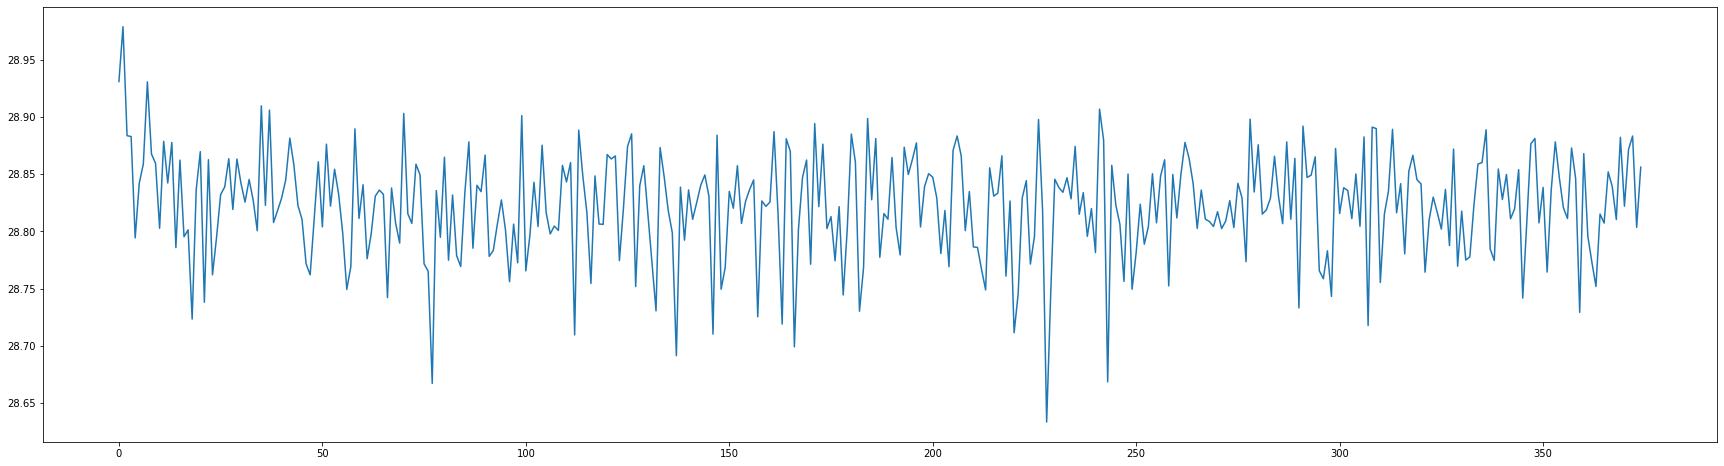

In [33]:
x = np.arange(len(Loss))
plt.figure(figsize=(30,8))
plt.plot(x,Loss)
plt.show()